# Treinamento de Modelo de Machine Learning usando AWS SageMaker

### Membros
* 2315530 - Clairton Carneiro Luz

## 1. Introdução

Este documento apresenta um guia para o treinamento de um modelo de Machine Learning utilizando o AWS SageMaker. O objetivo desta atividade é permitir a prática na implementação de um pipeline de aprendizado de máquina, desde a preparação do ambiente até a implantação do modelo treinado.


## 2. Objetivo

O objetivo desta atividade é desenvolver habilidades na utilização do AWS SageMaker para treinar e implantar modelos de Machine Learning. O processo envolve a criação de um ambiente adequado, manipulação de dados, treinamento do modelo, avaliação de desempenho e implantação para uso em produção.

## 3. Preparação do Ambiente:

   ### 3.1 Criar um notebook instance no SageMaker.

* Acesse o console AWS e vá para o serviço `Amazon SageMaker AI`.

* No painel esquerdo, clique em `Notebooks`.
* Clique em `Create notebook instance`.
* Defina um nome para a instância e escolha um tipo adequado, como ml.t3.medium.
* Em IAM role, selecione Create a new role, permitindo acesso ao Amazon S3.
* Clique em Create notebook instance e aguarde até que o status mude para InService.

* Agora faça o upload desse notebook para que possa executa-lo no ambiente em nuvem.

### 3.2 Configurar as permissões IAM para permitir o acesso ao S3 e SageMaker.

* No console AWS, vá para o serviço IAM.

* Clique em Roles e selecione a função atribuída ao notebook SageMaker.
* Em Permissões, adicione as políticas AmazonS3FullAccess e AmazonSageMakerFullAccess.
* Salve as alterações para garantir que o SageMaker possa acessar os recursos necessários.

### 3.3 Instalar as bibliotecas necessárias.

* Após iniciar o notebook, execute o seguinte comando para instalar as bibliotecas necessárias:

In [1]:
%pip install -q -U sagemaker pandas numpy scikit-learn kagglehub matplotlib seaborn
%pip install -q boto3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 4. Download e Preparação dos Dados:

### 4.1 Download dataset

In [2]:

import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("ankushpanday1/prostate-cancer-prediction-dataset")

print("Path to dataset files:", path)
df_original = pd.read_csv(path + "/prostate_cancer_prediction.csv", index_col=0)

df = df_original.copy()
df_original.head()

100%|██████████| 665k/665k [00:00<00:00, 40.1MB/s]

Extracting files...
Path to dataset files: /home/ec2-user/.cache/kagglehub/datasets/ankushpanday1/prostate-cancer-prediction-dataset/versions/1


,Age,Family_History,Race_African_Ancestry,PSA_Level,DRE_Result,Biopsy_Result,Difficulty_Urinating,Weak_Urine_Flow,Blood_in_Urine,Pelvic_Pain,...,Alcohol_Consumption,Hypertension,Diabetes,Cholesterol_Level,Screening_Age,Follow_Up_Required,Prostate_Volume,Genetic_Risk_Factors,Previous_Cancer_History,Early_Detection
Patient_ID,,,,,,,,,,,,,,,,,,,,,
1,78,No,Yes,5.07,Normal,Benign,No,No,No,No,...,Moderate,No,No,Normal,45,No,46.0,No,No,Yes
2,68,No,Yes,10.24,Normal,Benign,Yes,No,No,Yes,...,Low,No,No,High,65,No,78.2,No,No,Yes
3,54,No,No,13.79,Normal,Benign,No,No,No,Yes,...,Low,No,No,Normal,61,No,21.1,No,No,Yes
4,82,No,No,8.03,Abnormal,Benign,No,No,No,No,...,Low,No,No,Normal,47,Yes,79.9,No,Yes,Yes
5,47,Yes,No,1.89,Normal,Malignant,Yes,Yes,No,No,...,Moderate,Yes,No,Normal,72,No,32.0,No,No,Yes


### 4.2 Realizar a limpeza e pré-processamento dos dados (tratamento de valores faltantes, normalização, etc.).

In [3]:
df.shape

(27945, 29)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27945 entries, 1 to 27945
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      27945 non-null  int64  
 1   Family_History           27945 non-null  object 
 2   Race_African_Ancestry    27945 non-null  object 
 3   PSA_Level                27945 non-null  float64
 4   DRE_Result               27945 non-null  object 
 5   Biopsy_Result            27945 non-null  object 
 6   Difficulty_Urinating     27945 non-null  object 
 7   Weak_Urine_Flow          27945 non-null  object 
 8   Blood_in_Urine           27945 non-null  object 
 9   Pelvic_Pain              27945 non-null  object 
 10  Back_Pain                27945 non-null  object 
 11  Erectile_Dysfunction     27945 non-null  object 
 12  Cancer_Stage             27945 non-null  object 
 13  Treatment_Recommended    27945 non-null  object 
 14  Survival_5_Years         27

In [5]:
df.isna().sum()

Age                        0
Family_History             0
Race_African_Ancestry      0
PSA_Level                  0
DRE_Result                 0
Biopsy_Result              0
Difficulty_Urinating       0
Weak_Urine_Flow            0
Blood_in_Urine             0
Pelvic_Pain                0
Back_Pain                  0
Erectile_Dysfunction       0
Cancer_Stage               0
Treatment_Recommended      0
Survival_5_Years           0
Exercise_Regularly         0
Healthy_Diet               0
BMI                        0
Smoking_History            0
Alcohol_Consumption        0
Hypertension               0
Diabetes                   0
Cholesterol_Level          0
Screening_Age              0
Follow_Up_Required         0
Prostate_Volume            0
Genetic_Risk_Factors       0
Previous_Cancer_History    0
Early_Detection            0
dtype: int64

In [6]:
def create_map_encoder(categorias):
    map_encoder = dict(zip(categorias, range(len(categorias))))
    print("Mapa de Codificação:", map_encoder)
    return map_encoder

def map_label_encoder(df, columns, map_encoder):
    for column in columns:
        df[column] = df[column].map(map_encoder)
    return df

#### Converte valores String para numericos para treinamento do modelo

In [7]:
df = df_original.copy()

yes_no_map_encoder = create_map_encoder(["No", "Yes"])
columns_yes_no = ["Family_History", "Race_African_Ancestry", "Difficulty_Urinating", "Weak_Urine_Flow", "Blood_in_Urine", "Pelvic_Pain", "Back_Pain", "Erectile_Dysfunction",
                  "Survival_5_Years", "Exercise_Regularly", "Healthy_Diet", "Smoking_History", "Hypertension", "Diabetes", "Follow_Up_Required", "Previous_Cancer_History",
                  "Early_Detection", "Genetic_Risk_Factors"]
map_label_encoder(df, columns_yes_no, yes_no_map_encoder)

normal_abnormal_map_encoder = create_map_encoder(["Normal", "Abnormal"])
columns_normal_abnormal = ["DRE_Result"]
map_label_encoder(df, columns_normal_abnormal, normal_abnormal_map_encoder)

biopsy_result_map_encoder = create_map_encoder(["Benign", "Malignant"])
columns_biopsy_result = ["Biopsy_Result"]
map_label_encoder(df, columns_biopsy_result, biopsy_result_map_encoder)

cancer_stage_map_encoder = create_map_encoder(
    ["Localized", "Advanced", "Metastatic"])
columns_cancer_stage = ["Cancer_Stage"]
map_label_encoder(df, columns_cancer_stage, cancer_stage_map_encoder)

treatment_recommended_map_encoder = create_map_encoder(
    ["Active Surveillance", "Surgery", "Immunotherapy", "Radiation", "Hormone Therapy", "Chemotherapy"])
columns_treatment_recommended = ["Treatment_Recommended"]
map_label_encoder(df, columns_treatment_recommended,
                  treatment_recommended_map_encoder)

low_moderate_high_map_encoder = create_map_encoder(["Low", "Moderate", "High"])
columns_low_moderate_high = ["Alcohol_Consumption"]
map_label_encoder(df, columns_low_moderate_high, low_moderate_high_map_encoder)

normal_high_map_encoder = create_map_encoder(["Normal", "High"])
columns_normal_high = ["Cholesterol_Level"]
map_label_encoder(df, columns_normal_high, normal_high_map_encoder)

df.head()

Mapa de Codificação: {'No': 0, 'Yes': 1}
Mapa de Codificação: {'Normal': 0, 'Abnormal': 1}
Mapa de Codificação: {'Benign': 0, 'Malignant': 1}
Mapa de Codificação: {'Localized': 0, 'Advanced': 1, 'Metastatic': 2}
Mapa de Codificação: {'Active Surveillance': 0, 'Surgery': 1, 'Immunotherapy': 2, 'Radiation': 3, 'Hormone Therapy': 4, 'Chemotherapy': 5}
Mapa de Codificação: {'Low': 0, 'Moderate': 1, 'High': 2}
Mapa de Codificação: {'Normal': 0, 'High': 1}


,Age,Family_History,Race_African_Ancestry,PSA_Level,DRE_Result,Biopsy_Result,Difficulty_Urinating,Weak_Urine_Flow,Blood_in_Urine,Pelvic_Pain,...,Alcohol_Consumption,Hypertension,Diabetes,Cholesterol_Level,Screening_Age,Follow_Up_Required,Prostate_Volume,Genetic_Risk_Factors,Previous_Cancer_History,Early_Detection
Patient_ID,,,,,,,,,,,,,,,,,,,,,
1,78,0,1,5.07,0,0,0,0,0,0,...,1,0,0,0,45,0,46.0,0,0,1
2,68,0,1,10.24,0,0,1,0,0,1,...,0,0,0,1,65,0,78.2,0,0,1
3,54,0,0,13.79,0,0,0,0,0,1,...,0,0,0,0,61,0,21.1,0,0,1
4,82,0,0,8.03,1,0,0,0,0,0,...,0,0,0,0,47,1,79.9,0,1,1
5,47,1,0,1.89,0,1,1,1,0,0,...,1,1,0,0,72,0,32.0,0,0,1


In [8]:
# impleme o value count de todas as colunas
# para as columnas que foram feitas a codificação, mostre o valor original e o valor codificado
# por exemplo para a coluna Family_History, quantidade de Yes e No e o valor codificado e a quantidade de cada valor codificado
# exemplo no lugar de mostra quantidade de 0 e quantidade de 1 mostre quantidade de Yes e quantidade de No

def print_value_counts(df, column, map_encoder):
    print(column)
    counts = df[column].value_counts()
    if(map_encoder):
        counts.index = counts.index.map({v: k for k, v in map_encoder.items()})
    for( index, value) in counts.items():
        print(index, value)
    print()

for column in df.columns:
    if column in columns_yes_no:
        print_value_counts(df, column, yes_no_map_encoder)
    elif column in columns_normal_abnormal:
        print_value_counts(df, column, normal_abnormal_map_encoder)
    elif column in columns_biopsy_result:
        print_value_counts(df, column, biopsy_result_map_encoder)
    elif column in columns_cancer_stage:
        print_value_counts(df, column, cancer_stage_map_encoder)
    elif column in columns_treatment_recommended:
        print_value_counts(df, column, treatment_recommended_map_encoder)
    elif column in columns_low_moderate_high:
        print_value_counts(df, column, low_moderate_high_map_encoder)
    elif column in columns_normal_high:
        print_value_counts(df, column, normal_high_map_encoder)

Family_History
No 19604
Yes 8341

Race_African_Ancestry
No 22409
Yes 5536

DRE_Result
Normal 23742
Abnormal 4203

Biopsy_Result
Benign 19549
Malignant 8396

Difficulty_Urinating
No 21054
Yes 6891

Weak_Urine_Flow
No 19424
Yes 8521

Blood_in_Urine
No 25087
Yes 2858

Pelvic_Pain
No 22394
Yes 5551

Back_Pain
No 23669
Yes 4276

Erectile_Dysfunction
No 16704
Yes 11241

Cancer_Stage
Localized 19641
Advanced 5566
Metastatic 2738

Treatment_Recommended
Active Surveillance 4751
Surgery 4665
Immunotherapy 4655
Radiation 4642
Hormone Therapy 4634
Chemotherapy 4598

Survival_5_Years
Yes 25200
No 2745

Exercise_Regularly
Yes 16645
No 11300

Healthy_Diet
Yes 19579
No 8366

Smoking_History
No 19667
Yes 8278

Alcohol_Consumption
Low 13897
Moderate 11192
High 2856

Hypertension
No 16791
Yes 11154

Diabetes
No 22318
Yes 5627

Cholesterol_Level
Normal 19559
High 8386

Follow_Up_Required
No 14035
Yes 13910

Genetic_Risk_Factors
No 21013
Yes 6932

Previous_Cancer_History
No 25183
Yes 2762

Early_Detection


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27945 entries, 1 to 27945
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      27945 non-null  int64  
 1   Family_History           27945 non-null  int64  
 2   Race_African_Ancestry    27945 non-null  int64  
 3   PSA_Level                27945 non-null  float64
 4   DRE_Result               27945 non-null  int64  
 5   Biopsy_Result            27945 non-null  int64  
 6   Difficulty_Urinating     27945 non-null  int64  
 7   Weak_Urine_Flow          27945 non-null  int64  
 8   Blood_in_Urine           27945 non-null  int64  
 9   Pelvic_Pain              27945 non-null  int64  
 10  Back_Pain                27945 non-null  int64  
 11  Erectile_Dysfunction     27945 non-null  int64  
 12  Cancer_Stage             27945 non-null  int64  
 13  Treatment_Recommended    27945 non-null  int64  
 14  Survival_5_Years         27

Matplotlib is building the font cache; this may take a moment.


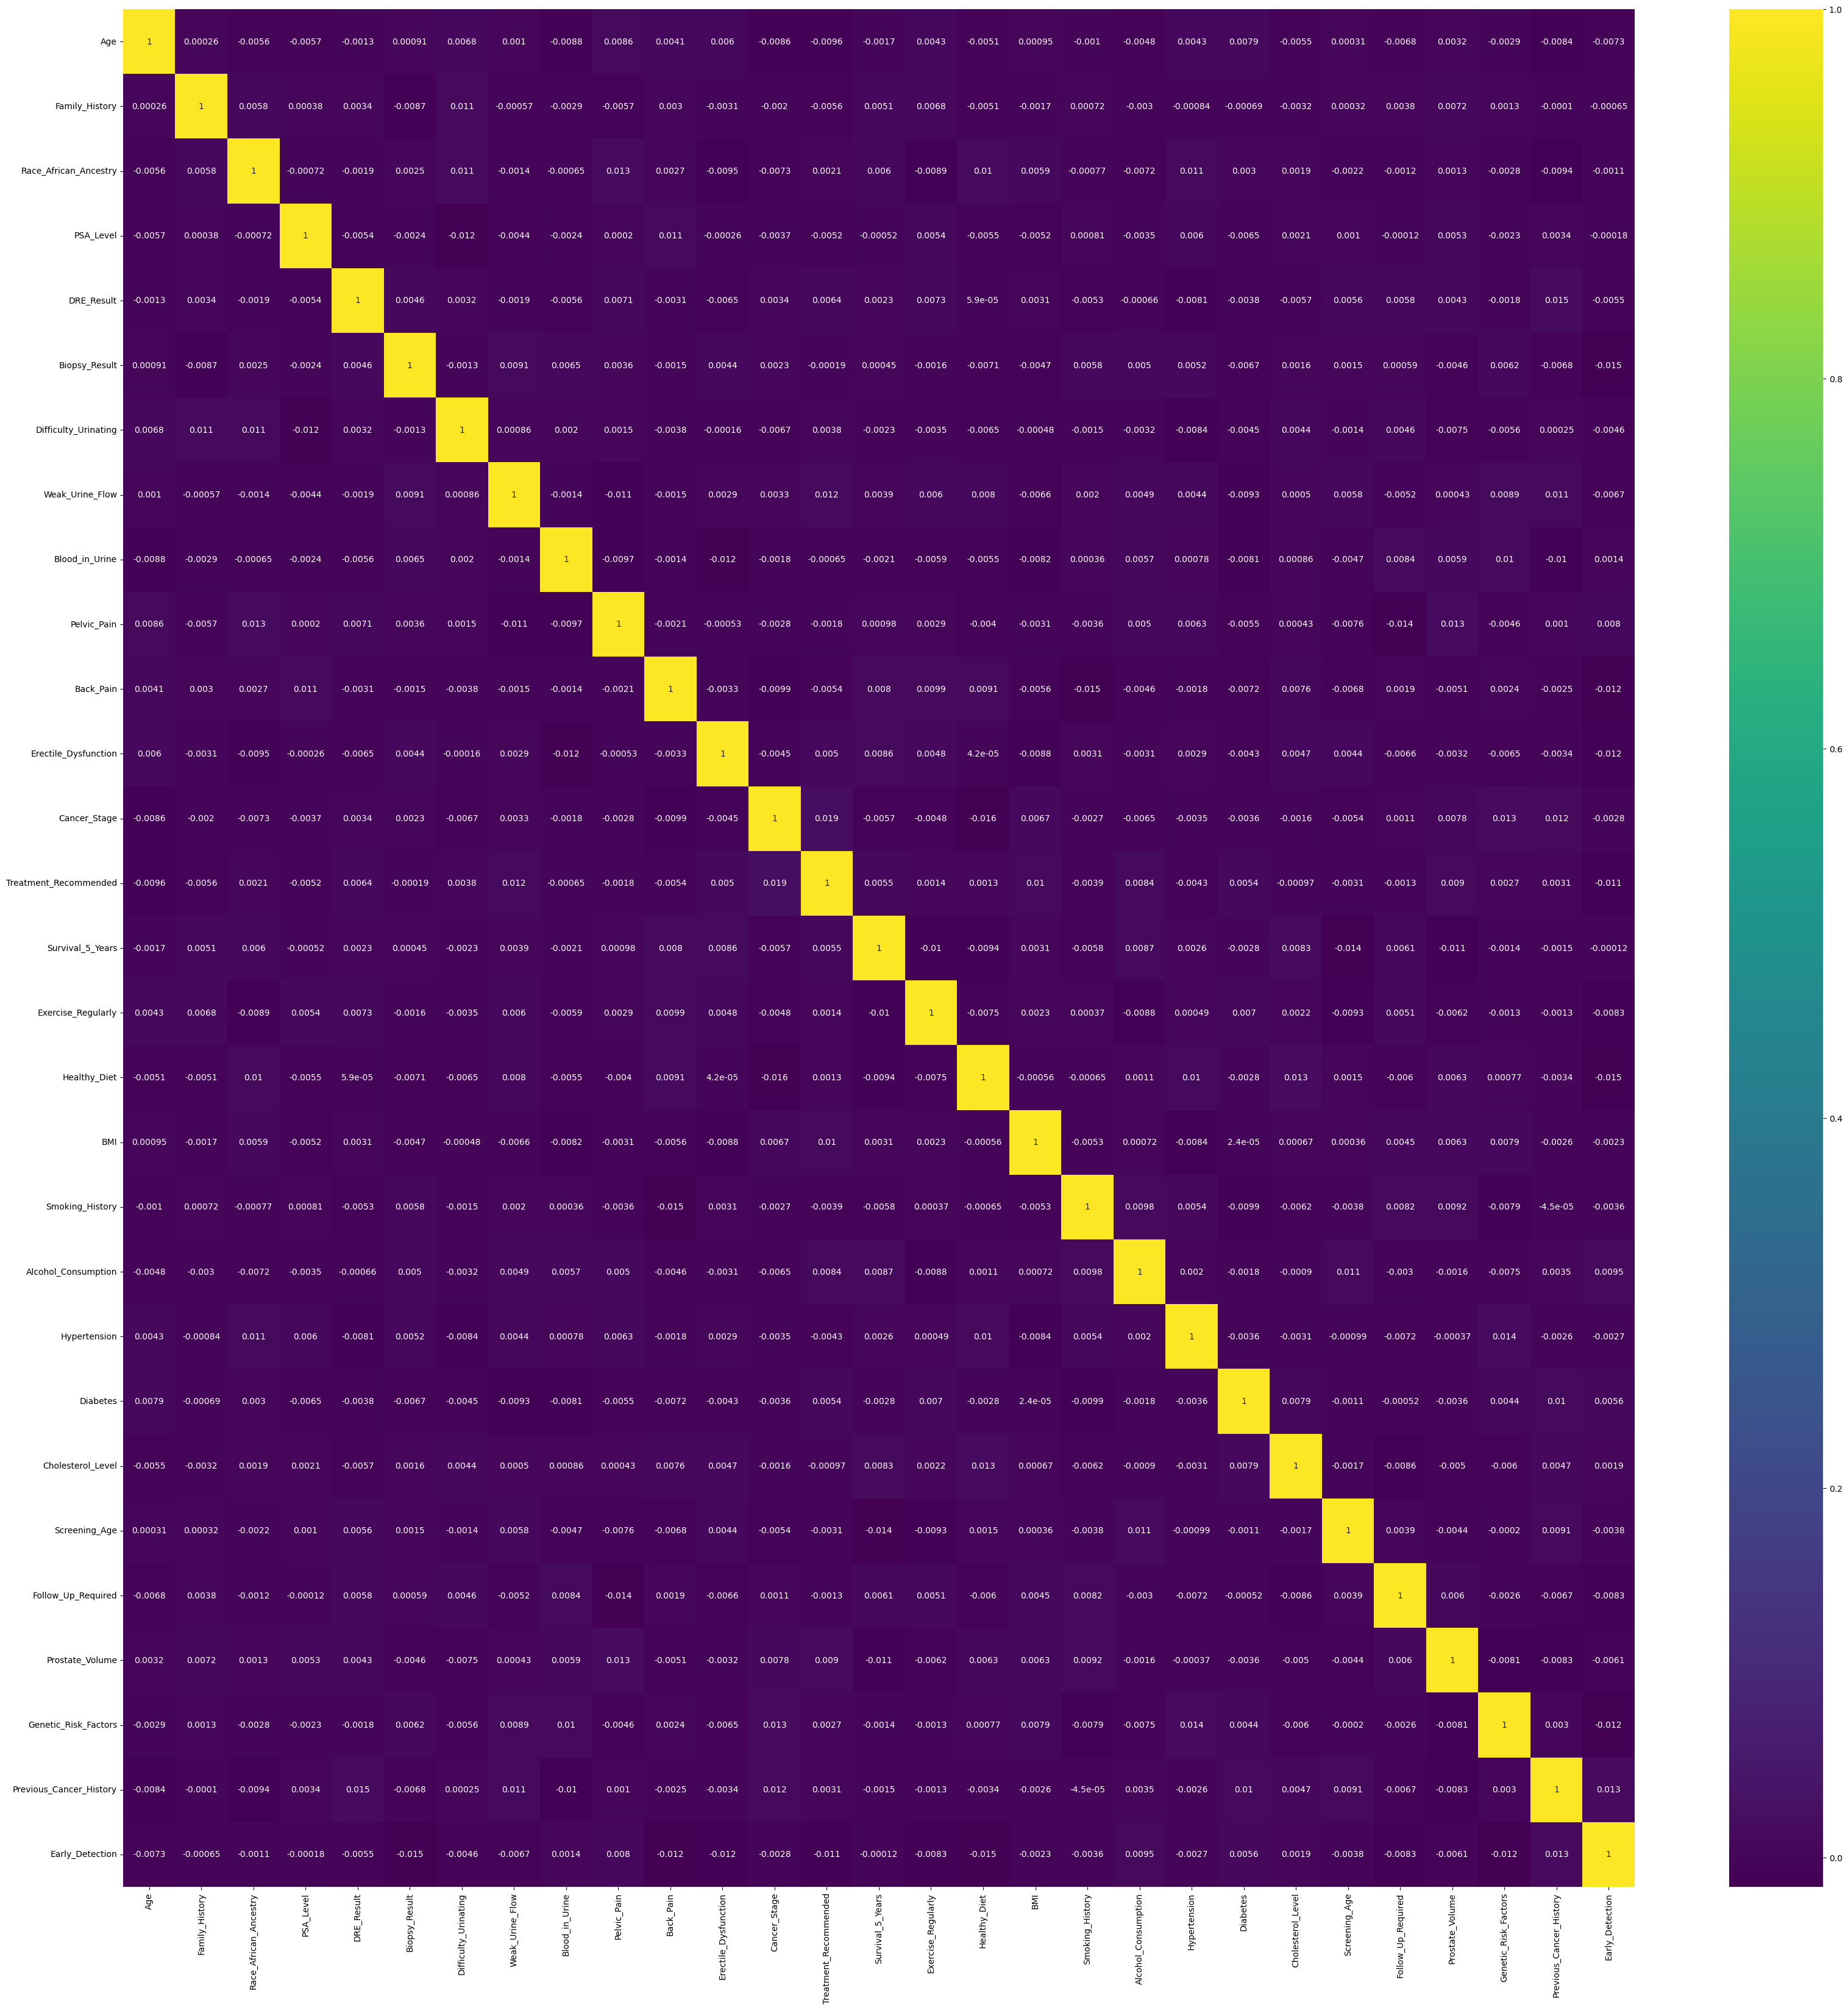

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (40, 40))
sns.heatmap(df.corr(), annot = True, fmt = ".2g", cmap = "viridis")
plt.show()

## 5 Dividir o dataset em conjuntos de treino e teste.

### 5.1 Separando features e target

In [11]:
import numpy as np

X = df.drop("Early_Detection", axis = 1)
y = df["Early_Detection"]

### 5.2 Separando treino, teste e validação

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## 6. Armazenamento dos Dados no S3:

### 6.1 Criar um bucket S3.

* No console AWS, vá para o serviço S3.

* Clique em Create bucket e defina um nome único.

* Configure permissões adequadas e finalize a criação.


#### Outra opção é utilizar o bucket default que o sagemaker já configura pra você com o comando `sagemaker_session.default_bucket()`

### 6.2 Upload dos dados de treino, teste e validação para o bucket S3.

In [13]:
# Salvando os dados de treino, teste e validação no s3
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
prefix = "prostate-cancer-prediction"
# caso queira utilizar um bucket especifico usa a linha abaixo para definir o bucket no lugar da linha acima.
# bucket = "unifor-aws-sagemake"

train_file = "train.csv"
test_file = "test.csv"

pd.concat([pd.DataFrame(y_train), pd.DataFrame(X_train)],
          axis=1).to_csv(train_file, header=False, index=False)
pd.concat([pd.DataFrame(y_test), pd.DataFrame(X_test)],
          axis=1).to_csv(test_file, header=False, index=False)

sagemaker_session.upload_data(train_file, bucket, prefix + "/train")
sagemaker_session.upload_data(test_file, bucket, prefix + "/test")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[02/08/25 15:52:52] INFO     Found credentials from IAM Role:                                   ]8;id=145198;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=392748;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[02/08/25 15:52:54] INFO     Found credentials from IAM Role:                                   ]8;id=950254;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=418248;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[02/08/25 15:52:55] INFO     Found credentials from IAM Role:                                   ]8;id=830448;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=273274;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

's3://sagemaker-us-east-1-277459972422/prostate-cancer-prediction/test/test.csv'

## 7. Treinamento do Modelo:

### 7.1 Escolher um algoritmo de machine learning disponível no SageMaker (por exemplo, XGBoost).

In [15]:
# URL do container do XGBoost disponível no SageMaker
container = sagemaker.image_uris.retrieve("xgboost", sagemaker_session.boto_region_name, "1.5-1")


[02/08/25 15:57:39] INFO     Ignoring unnecessary instance type: None.                            ]8;id=569705;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=223338;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

### 7.2 Configurar o job de treinamento no SageMaker.

In [17]:
from sagemaker.estimator import Estimator

# Criando o Estimator XGBoost
xgboost = Estimator(
    image_uri=container,
    instance_type="ml.m5.large",
    instance_count=1,
    role=role,
    sagemaker_session=sagemaker_session,
    hyperparameters={
        "max_depth": 5,
        "eta": 0.2,
        "objective": "binary:logistic",
        "num_round": 100,
    }
)


### 7.3 Iniciar o treinamento do modelo utilizando os dados armazenados no S3.

In [22]:
# Treinando o modelo
from sagemaker.inputs import TrainingInput

train_input = TrainingInput(
    train_file,
    content_type="text/csv"
)

# for model_name, estimator in models.items():
#     estimator.fit({"train": train_input})


In [ ]:
xgboost.fit({"train": train_input})

[02/08/25 16:01:23] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=33977;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=937631;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=106969;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=896456;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-02-08-16-01-23-137                                             

2025-02-08 16:01:24 Starting - Starting the training job...
..25-02-08 16:01:38 Starting - Preparing the instances for training.
..25-02-08 16:02:04 Downloading - Downloading input data.
.025-02-08 16:02:44 Downloading - Downloading the training image.

In [ ]:
# Implantando o modelo
predictor = xgboost.deploy(
    initial_instance_count=1, 
    instance_type="ml.m5.large"
)

## 8. Avaliação do Modelo:

### 8.1 Realizar previsões utilizando o conjunto de teste.

In [ ]:
# Avaliação dos modelos
from sagemaker.serializers import CSVSerializer
from sagemaker.predictor import Predictor
from sklearn.metrics import root_mean_squared_error

best_model = "xboost"
best_rmse = float("inf")
# rmse_scores = {}

# models2 = {
#     "xgboost": models["xgboost"]
# }

# for model_name, estimator in models.items():
#     print(estimator.latest_training_job.name)
#     predictor = Predictor(
#         endpoint_name=estimator.latest_training_job.name,
#         sagemaker_session=sagemaker_session,
#         serializer=CSVSerializer()
#     )


y_pred = np.array([float(xgb_predictor.predict(x)) for x in X_test])
rmse = root_mean_squared_error(y_test, y_pred)
print(f"{model_name}: RMSE = {rmse}")


In [ ]:
# imprima um grafico que mostre a curva de aprendizado do modelo mostrando a linha o rmse do treino e do teste
# conforme o numero de amostras aumenta

import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(model, X_train, y_train, X_test, y_test):
    train_rmse = []
    test_rmse = []
    for i in range(1, len(X_train) + 1):
        model.fit(X_train[:i], y_train[:i])
        y_train_pred = model.predict(X_train[:i])
        y_test_pred = model.predict(X_test)
        train_rmse.append(np.sqrt(mean_squared_error(y_train[:i], y_train_pred)))
        test_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_pred))
    plt.plot(train_rmse, label="train")
    plt.plot(test_rmse, label="test")
    plt.xlabel("Number of samples")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()
    
plot_learning_curve(models["xgboost"], X_train, y_train, X_test, y_test)



In [ ]:

import numpy as np

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

y_pred = predict(X_test)
y_pred = np.array(y_pred)

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot(range(0, 20), range(0, 20), color="red")
plt.xlabel("True Price")
plt.ylabel("Predicted Price")

plt.show()

In [ ]:

s3_client = sagemaker_session.boto_session.client("s3")
response = s3_client.get_object(
    Bucket=bucket, Key=f"{prefix}/output/test.csv.out")
response_body = response["Body"].read()

predictions = pd.read_csv(io.BytesIO(response_body), header=None)
predictions = predictions.squeeze()


mean_squared_error(y_test, predictions)

### 8.2 Avaliar o desempenho do modelo utilizando métricas apropriadas (acurácia, precisão, recall, F1-score).

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R2:", r2)


### 8.3 Gerar um relatório de avaliação.

In [ ]:
import boto3

# Testando o modelo
y_pred = predictor.predict(X_test)

from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)



# Salvando o modelo
model_path = sklearn.model_data
model_path

boto3.Session().resource("s3").Bucket(bucket).download_file(model_path, "model.tar.gz")

## 9. Implantação do Modelo:

### 9.1 Implantar o modelo treinado como um endpoint no SageMaker.

In [ ]:
# Deploy do modelo
predictor = sklearn.deploy(
    initial_instance_count = 1,
    instance_type = "ml.t2.medium"
)

### 9.2 Testar o endpoint realizando previsões em tempo real.

In [ ]:
# validando o modelo
y_pred = predictor.predict(X_val)

mean_squared_error(y_val, y_pred)

### 9.3 Removendo endpoint

In [ ]:
# Deletando o endpoint
predictor.delete_endpoint()